# Calculate data for REZ regions

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:05:00'
cores = 2
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46445 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.46.35:46445/status,
Dashboard: http://10.6.46.35:46445/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.46.35:41585,Workers: 0
Dashboard: http://10.6.46.35:46445/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
import xarray as xr
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

In [7]:
import functions as fn

plt_params = fn.get_plot_params()

# Load REZ mask

In [8]:
rez_mask = xr.open_dataset(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_mask_era5_grid.nc'
).REZ

# Load gridded data

First look at daily (1400). Have already looked at hourly and daily (0000).

In [9]:
years = range(1959, 2021)

Mean solar shortwave radiation downwards

In [10]:
mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    consolidated=True
)

100m wind speed

In [11]:
w100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    consolidated=True
)

# Calculate regional averages

In [12]:
def REZ_spatial_mean(da, region):
    region_mask = rez_mask.sel(region=region)
    return da.where(region_mask, drop=True).mean(['lat', 'lon'], skipna=True)

In [13]:
def calculate_spatial_means(da):
    
    da_list = []
    for region in rez_mask['region'].values:
        region_mean = REZ_spatial_mean(da, region)
        da_list.append(region_mean)
        
    da_concat = xr.concat(
        da_list,
        dim='region'
    )
    return da_concat

In [14]:
rez_100w = calculate_spatial_means(w100['w100']).compute()

In [15]:
rez_mssrd = calculate_spatial_means(mssrd['msdwswrf']).compute()

# How often to regional means exceed operational thresholds?

- For wind, we use 4 m/s (Ridder report)
- For solar, use 170 W/m^2 (Prasad 2021), or 95 W/m^2 (calculated from 342 kJ/hr in Ridder report using https://www.unitconverters.net/power/kilojoule-hour-to-watt.htm)

In [16]:
thresh_100w = 4
thresh_mssrd = 170

In [17]:
def get_events(da, thresh, tail='lower'):
    if tail == 'lower':
        return xr.where(da < thresh, 1, 0)
    else:
        raise ValueError('Incorrect string for tail')

In [18]:
def calculate_event_frequency(da, thresh, tail='lower',
                             time_name='time'):
    T = len(da[time_name].values)
    events = get_events(da, thresh, tail)
    freq = events.sum(time_name) / T
            
    return freq

In [19]:
freq_100w = calculate_event_frequency(rez_100w, thresh_100w)

In [20]:
freq_mssrd = calculate_event_frequency(rez_mssrd, thresh_mssrd)

In [71]:
def get_regions_from_region_codes(region_codes):
    regions = [rez_mask.region.values[i] for i in range(len(rez_mask.region.values)) if
               rez_mask.region_code.values[i] in region_codes]
    return regions

In [72]:
def plot_freq(da, region_codes=range(1,8), vmin=0, vmax='max'):

    with plt.rc_context(plt_params):
        regions = get_regions_from_region_codes(region_codes)
        plot_da = xr.where(rez_mask.sel(region=regions),
                           da.sel(region=regions),
                           np.nan).sum('region', skipna=True)
        plot_da = plot_da.where(rez_mask.sel(region=regions).sum('region'))
        
        if vmax == 'max':
            data_max = plot_da.max().values
            if data_max > 0.2:
                vmax=fn.round_decimals_up(data_max, 1)
                cbar_tick_intervals = 0.1
            else:
                vmax=fn.round_decimals_up(data_max, 2)
                cbar_tick_intervals = 0.01

        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
        ax.coastlines()
        ax.add_feature(
            cartopy.feature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces',
                                                scale='10m'),
            facecolor='none', edgecolor='k', lw=plt_params['lines.linewidth'] / 3
        )

        plot_da.plot(ax=ax, vmin=vmin, vmax=vmax,
                    cbar_kwargs={
                        'ticks': np.arange(vmin, vmax+.1, cbar_tick_intervals),
                        'label': 'Relative frequency [-]'
                    })

### Solar lulls

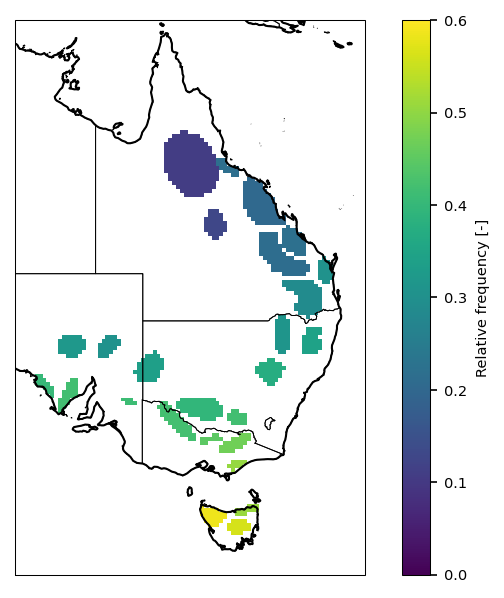

In [73]:
plot_freq(freq_mssrd, region_codes=[2, 3, 6, 7])

### Wind lulls

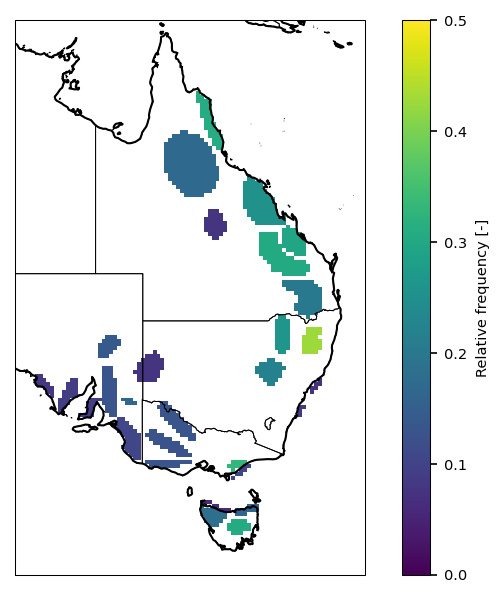

In [31]:
plot_freq(freq_100w, region_codes=[1, 3, 5, 7])

### Simultaneous wind and solar lulls

In [32]:
freq_100w_mssrd = xr.where(
    (rez_100w < thresh_100w) &
    (rez_mssrd < thresh_mssrd),
    1, 0
).sum('time') / len(rez_100w.time.values)

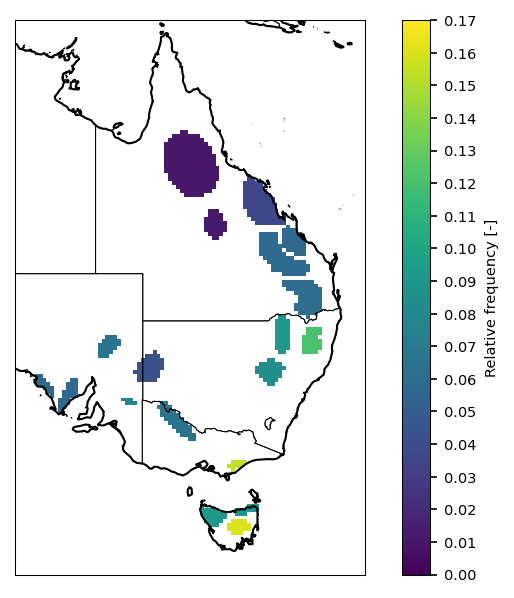

In [33]:
plot_freq(freq_100w_mssrd, region_codes=[3, 7])

# How often do these lulls occur simultaneously across regions?

In [22]:
events_100w = get_events(rez_100w, thresh_100w)

In [23]:
events_mssrd = get_events(rez_mssrd, thresh_mssrd)

### Avg number of regions per year experiencing lulls

#### Wind

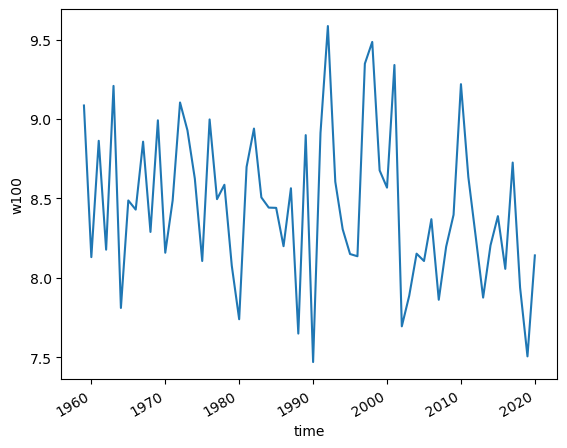

In [56]:
events_100w.sum('region').resample(time='1YS').mean().plot()

#### Solar

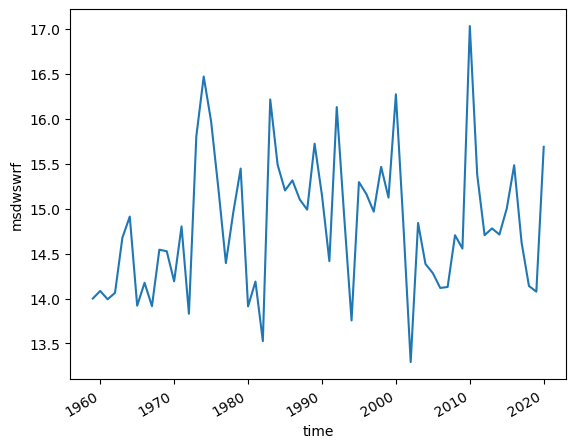

In [57]:
events_mssrd.sum('region').resample(time='1YS').mean().plot()

#### Both

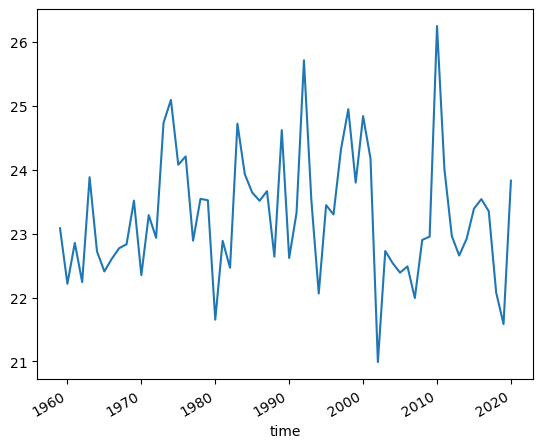

In [61]:
(events_100w + events_mssrd).sum('region').resample(time='1YS').mean().plot()

### Can we do a lego plot with days on the x and years on the y?

Could do one for each state, one for each energy type, one all together

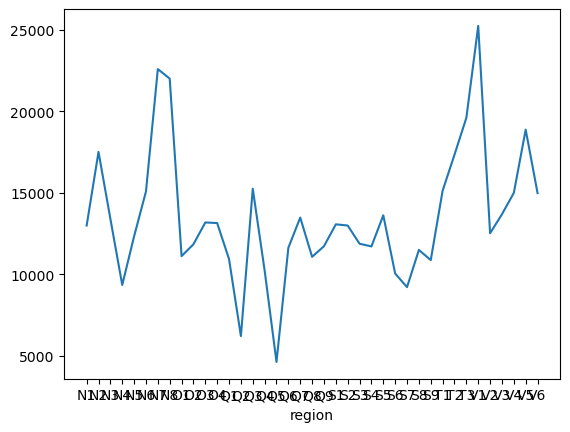

In [64]:
(events_100w + events_mssrd).sum('time').plot()

Remove leap year days (29/02) so that dayofyear can be used

In [24]:
i_leapdays = np.where(
    (events_100w.time.dt.month == 2) &
    (events_100w.time.dt.day == 29)
)[0]

In [25]:
i_exclude_leapdays = [i for i in range(len(events_100w.time)) if i not in i_leapdays]

In [55]:
def to_dayofyear(ds):
    """
    Reshapes array from time to year and dayofyear. Leap year days are manually
    removed, and days after this are reassigned as if there was no leap year.
    So dayofyear is always 1-365.
    
    Adapted from: https://github.com/pydata/xarray/discussions/5119#discussioncomment-581232
    """
    from itertools import cycle
    
    year = ds.time.dt.year
    day_cycle = cycle(range(1, 366))
    day = np.array([next(day_cycle) for _ in year])

    # assign new coords
    ds = ds.assign_coords(
        year=("time", year.data),
        dayofyear=("time", day)
    )

    # reshape the array to (..., "month", "year")
    return ds.set_index(
        time=("year", "dayofyear")
    ).unstack("time") 

In [56]:
w100_2d = to_dayofyear(events_100w.isel(time=i_exclude_leapdays))
mssrd_2d = to_dayofyear(events_mssrd.isel(time=i_exclude_leapdays))

In [147]:
dw = w100_2d.sel(region='V2') * 2

In [148]:
ds = mssrd_2d.sel(region='V2')

In [149]:
d = dw+ds

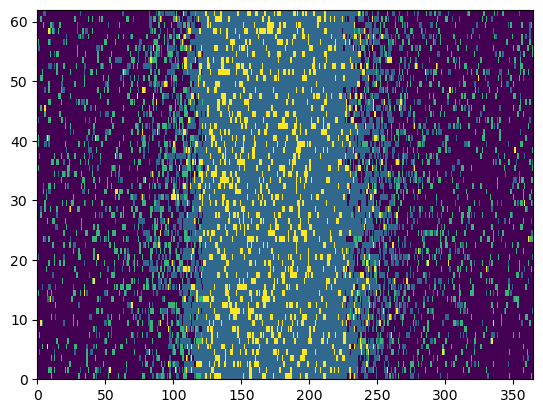

In [150]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')
cmapBig = matplotlib.cm.get_cmap('viridis', 512)
cmap_max=512
cbar_max = 4.5
newcmap = matplotlib.colors.ListedColormap(cmapBig(np.linspace(0, 1, cmap_max//2)))
norm = matplotlib.colors.BoundaryNorm(np.arange(cbar_max + 0.5), newcmap.N)

fig, ax = plt.subplots(1, 1)

ax.pcolormesh(d.data, cmap=cmap, norm=norm)

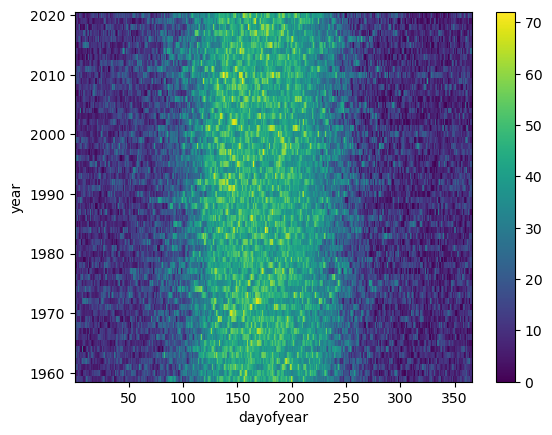

In [66]:
(w100_2d + mssrd_2d).sum('region').plot()

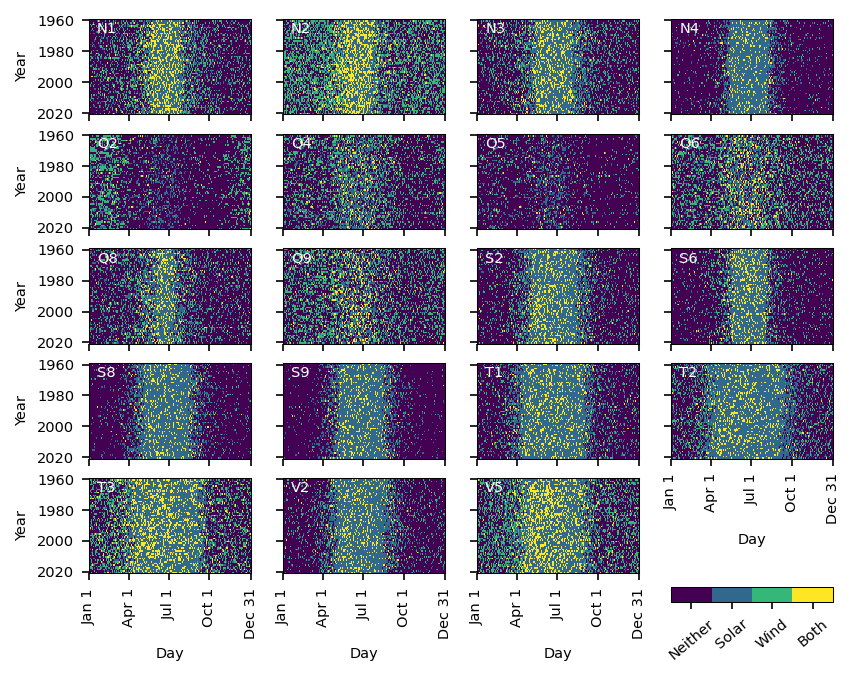

In [170]:
regions = get_regions_from_region_codes([3, 7])
d = mssrd_2d + w100_2d * 2

cmap = matplotlib.cm.get_cmap('viridis')
cmapBig = matplotlib.cm.get_cmap('viridis', 512)
cmap_max = 512
cbar_max = 4.5
newcmap = matplotlib.colors.ListedColormap(cmapBig(np.linspace(0, 1, cmap_max//2)))
norm = matplotlib.colors.BoundaryNorm(np.arange(cbar_max + 0.5), newcmap.N)

with plt.rc_context(plt_params):
    fig, ax = plt.subplots(5, 4, dpi=150)
    
    for i, region in enumerate(regions):
        # d.sel(region=region).plot(ax=ax.flatten()[i],
        #                           add_colorbar=False)
        p = ax.flatten()[i].pcolormesh(
            d.sel(region=region).data,
            cmap=cmap, norm=norm
        )
        ax.flatten()[i].set_ylim(ax.flatten()[i].get_ylim()[::-1])
        
        ax.flatten()[i].set_title('')
        ax.flatten()[i].text(0.05, 0.85, region,
                             c='w', transform=ax.flatten()[i].transAxes)
        
        if i in [0, 4, 8, 12, 16]:
            ax.flatten()[i].set_ylabel('Year')
            ax.flatten()[i].set_yticks(range(1, 81, 20))
            ax.flatten()[i].set_yticklabels(range(1960, 2021, 20))
        else:
            ax.flatten()[i].set_ylabel('')
            ax.flatten()[i].set_yticks(range(1, 81, 20))
            ax.flatten()[i].set_yticklabels('')
            
        if i > 14:
            ax.flatten()[i].set_xlabel('Day')
            ax.flatten()[i].set_xticks([0, 90, 181, 272, 365])
            ax.flatten()[i].set_xticklabels(['Jan 1', 'Apr 1', 'Jul 1', 'Oct 1', 'Dec 31'],
                                           rotation=90)
        else:
            ax.flatten()[i].set_xlabel('')
            ax.flatten()[i].set_xticks([0, 90, 181, 272, 365])
            ax.flatten()[i].set_xticklabels('')
            
    ax.flatten()[-1].axis('off')
    
    axins1 = inset_axes(ax.flatten()[-1], width="200%", height="20%",
                        bbox_to_anchor=(.5, -0.3, .5, .8),
                        bbox_transform=ax.flatten()[-1].transAxes, loc='lower right', borderpad=0)
    cb1 = fig.colorbar(p, cax=axins1, orientation='horizontal', ticks=np.arange(0.5, cbar_max, 1))
    cb1.ax.minorticks_off()
    cb1.ax.set_xticklabels(['Neither', 'Solar', 'Wind', 'Both'], rotation=40)

# Close cluster

In [52]:
client.close()
cluster.close()